In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [3]:
scale = 1
rod_length = 0.07244622391567243 * scale
width = rod_length / 20 * 10 
thickness = width / 10 * 0.35 
print(width, thickness)
io = InputOrganizer('kleinbottle_projected_{}'.format(scale), thickness, width, weaving_dir)

0.036223111957836215 0.0012678089185242675


In [4]:
import py_newton_optimizer
# Optimization parameters.
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 0.01
sw = 10
drw = 0.01
dsw = 0.1

In [5]:
import pickle 
import gzip

In [6]:
curved_linkage = pickle.load(gzip.open('{}_stage_2_20210105.pkl.gz'.format(io.MODEL_NAME), 'r'))
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
set_surface_view_options(curved_linkage_view, linkage_color='lightgreen')
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [ ]:
# curved_linkage.setDesignParameters(np.load('../../nature_paper_experiments/figure_1/results/bird_close_beak_1/bird_close_beak_1_dof.npy')[curved_linkage.numDoF():])

In [ ]:
curved_linkage.attraction_weight = 1e-5

In [ ]:
def eqm_callback(prob, i):
#     curved_linkage_view.update()
    pass

In [ ]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

In [ ]:
curved_linkage_view.update()

In [ ]:
# import pickle
# import gzip
# pickle.dump(curved_linkage, gzip.open('{}_stage_2_20210105.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [ ]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis

In [ ]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [ ]:
# optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, inner_gradTol = 1e-6)

In [ ]:
# optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e8, normalWeight = 20, torqueWeight = 0, maxIter=2000, normalActivationThreshold=-1e-7)

In [ ]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

In [ ]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [ ]:
import pickle
import gzip
pickle.dump(curved_linkage, gzip.open('{}_stage_2_20210105_after_flipping_1.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [ ]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

In [ ]:
third_structure_view = get_structure_analysis_view(curved_linkage)
third_structure_view.show()

In [ ]:
import pickle
import gzip
pickle.dump(curved_linkage, gzip.open('{}_stage_2_20210105_after_flipping_2.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [ ]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

In [ ]:
fourth_structure_view = get_structure_analysis_view(curved_linkage)
fourth_structure_view.show()

In [ ]:
import pickle
import gzip
pickle.dump(curved_linkage, gzip.open('{}_stage_2_20210105_after_flipping_3.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, inner_gradTol = 1e-6)

In [ ]:
from structural_analysis import weavingCrossingForceMagnitudes
cfm = weavingCrossingForceMagnitudes(curved_linkage, True)
normalActivationThreshold = np.percentile(cfm[:, 0], 75)

In [ ]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e6, normalWeight = 10, torqueWeight = 0, maxIter=2000, normalActivationThreshold=normalActivationThreshold)

### vector visualization

In [7]:
list_of_pickle_name = ['{}_stage_2_20210105.pkl.gz'.format(io.MODEL_NAME), '{}_stage_2_20210105_after_flipping_1.pkl.gz'.format(io.MODEL_NAME), '{}_stage_2_20210105_after_flipping_2.pkl.gz'.format(io.MODEL_NAME), '{}_stage_2_20210105_after_flipping_3.pkl.gz'.format(io.MODEL_NAME)]
list_of_output_name = ['{}_stage_2'.format(io.MODEL_NAME), '{}_flip_1'.format(io.MODEL_NAME), '{}_flip_2'.format(io.MODEL_NAME), '{}_flip_3'.format(io.MODEL_NAME)]

In [9]:
'{}_stage_2_20210105.pkl.gz'.format(io.MODEL_NAME)

'kleinbottle_projected_1_stage_2_20210105.pkl.gz'

In [8]:
import force_vector_visualization_helper
importlib.reload(force_vector_visualization_helper)
from force_vector_visualization_helper import write_force_vector_visualization_file
write_force_vector_visualization_file(list_of_pickle_name, list_of_output_name)

0	1.182e-05	4.63065e-09	4.63065e-09	0	0
0	1.18394e-05	4.17284e-09	4.17284e-09	0	0
0	1.18411e-05	6.3153e-09	6.3153e-09	0	0
0	1.18447e-05	3.5488e-09	3.5488e-09	0	0


In [16]:
    os.chdir(save_path)

0	1.182e-05	4.63065e-09	4.63065e-09	0	0
20520 20520
Min Width  0.018111555978918108
Scale:  276.06683853226144
num seg per rod 120
num seg per rod 120
num seg per rod 120
num seg per rod 120
num seg per rod 120
num seg per rod 120
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
1492.6263498236474 766.9388076080202
1492.6263498236474 806.6254066649011
1977.7524060605529 806.6254066649011
2180.5811291171367 806.6254066649011
2180.5811291171367 806.6254066649011
2180.581129117

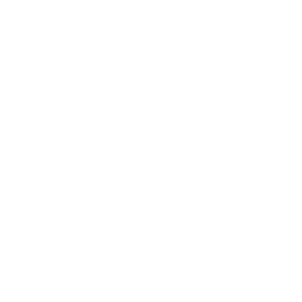

In [17]:
for pickle_name in list_of_pickle_name:
    curved_linkage = pickle.load(gzip.open(pickle_name, 'r'))
    curved_linkage.attraction_weight = 1e-5
    def eqm_callback(prob, i):
#     curved_linkage_view.update()
        pass
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    save_path = os.getcwd()
    write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, pickle_name[:-7], pickle_name[:-7], False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
    os.chdir(save_path)